# Bias types (Kilosort 3.0)

author: steeve.laquitaine@epfl.ch  
last modified: 13-02-2024
status: OK  
regression: None  

Purpose: Characterize and quantify ground truth sorting quality and biases from matching with best matching sorted units

Notes:
* pros of Kilosort 3.0:
    * fully automated to produce single units (isolated from multi-units via additional postprocessing label "KSlabel")
    * very efficient algorithm
    * very recent and well maintained, was very easy to setup and run from SpikeInterface
    * the most used and cited by recent studies, in high-impact papers


We define biases types to characterize what happens to the true units (not with respect to sorted unit). This allows the proportion of all biases to sum to 100% over true units.

Based on our definitions:

* Possible biases types are:  
    * well detected
    * well detected + correlated unit
    * poorly detected    
    * oversplit
    * overmerged (include overmerged + poorly detected because this combination is always due to overmerging)   
    * overmerged + oversplit
    * overmerged + well detected + correlated unit
    * below chance    
    * missed
* Impossible biases types are:
    * poorly detected + oversplit (impossible because poorly detected requires matching at max a single sorted unit above chance, while oversplit requires matching at least two units)


To detect overmerged units and combinations

* need to look from perspective of sorted units
* A true unit is overmerged (with other true units) if it has at least one sorted units with a score between detection and chance that also has a score between detection and chance with another true unit.
* a poorly sorted units (accuracy between 0.1 and 0.8) can thus be overmerged (it fuse together half the spike trains of two true units). In that case it is classified as overmerged.


### Setup

Create or activate env `npx_10m_384ch_unit_classes`

In [2]:
%load_ext autoreload
%autoreload 2
import os 
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns 
import spikeinterface as si

proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(proj_path)

from src.nodes.postpro.cell_matching import get_SpikeInterface_matching_object, match_sorted_to_true_neuropixels_2023_02_19
from src.nodes.utils import get_config
from src.nodes.postpro.feateng import (add_firing_rates)
from src.nodes.postpro import spikestats

# set classification parameters
LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot" (sparse units)
DET_THRESH = 0.8
CHANCE_THRESH = 0.1

# buccino
data_conf, param_conf = get_config("buccino_2020", "2020").values()
KS3_SORTING_PATH_b = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH_b = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_b = data_conf["recording"]["output"]
KS3_SORTING_PATH_b = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# silico marques
data_conf, param_conf = get_config("silico_neuropixels", "2023_10_18").values()
KS3_SORTING_PATH_m = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH_m = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_m = data_conf["recording"]["output"]
KS3_SORTING_PATH_m = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# silico horvath
data_conf, param_conf = get_config("silico_horvath", "concatenated/probe_1").values()
KS3_SORTING_PATH_h = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH_h = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_h = data_conf["recording"]["output"]
KS3_SORTING_PATH_h = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# silico stimulus
data_conf, param_conf = get_config("silico_neuropixels", "stimulus").values()
KS3_SORTING_PATH_e = data_conf["sorting"]["sorters"]["kilosort3"]["output"]
GT_SORTING_PATH_e = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_e = data_conf["recording"]["output"]
KS3_SORTING_PATH_e = data_conf["sorting"]["sorters"]["kilosort3"]["output"]


# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (1,1)
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.2
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

2024-02-15 09:14:55,775 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-15 09:14:55,790 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-02-15 09:14:55,791 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-15 09:14:55,814 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-02-15 09:14:55,816 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-15 09:14:55,836 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-02-15 09:14:55,837 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-15 09:14:55,866 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Define custom functions

In [5]:
def format_agreement_matrix(MatchingObject):

    # get sorted x true units' agreement scores
    overmerging_matx = MatchingObject.agreement_scores.T

    # sort each row such that the row with the highest score be first, while column order stays unchanged
    argmax = overmerging_matx.T.idxmax().to_frame()
    max = overmerging_matx.T.max()
    descending_ix = np.argsort(max)[::-1]
    overmerging_matx_2 = overmerging_matx.iloc[descending_ix]

    # repeat for columns, row order stays auntouched
    max = overmerging_matx_2.max()
    descending_ix = np.argsort(max)[::-1]
    return overmerging_matx_2.iloc[:, descending_ix]

### Stuffs

In [3]:
MatchingObject_m = get_SpikeInterface_matching_object(
    GT_SORTING_PATH_m, KS3_SORTING_PATH_m
)

In [6]:
agreem_mx_m = format_agreement_matrix(MatchingObject_m)

In [8]:
# marques
Sorting = si.load_extractor(KS3_SORTING_PATH_m)
agreem_mx_m = agreem_mx_m.loc[
    Sorting.unit_ids[Sorting.get_property("KSLabel") == "good"], :
]

In [110]:
det_thresh = 0.8
chance = 0.1

mask_above_det = agreem_mx_m >= det_thresh
mask_below_chance = agreem_mx_m <= chance

gt_classes = []

# loop over single sorted units
for s_i in range(agreem_mx_m.shape[0]):

    # good units
    if any(mask_above_det.iloc[s_i, :]):

        is_detected = mask_above_det.iloc[s_i, :]
        detected_loc = np.where(is_detected)[0]
        detected_ix = is_detected.index[detected_loc]

        # get other cells
        other_cells_ix = is_detected.drop(index=detected_ix).index

        # get this ground truth below chance stata
        is_below_chance = mask_below_chance.iloc[s_i, :]

        # check if all other sorted units are below chance
        if all(is_below_chance.loc[other_cells_ix]):
            gt_classes.append("well detected")
    elif any(agreem_mx_m.iloc[s_i, :] >= chance) and (
        any(agreem_mx_m.iloc[s_i, :] < det_thresh)
    ):
        gt_classes.append("poorly detected")
    else:
        gt_classes.append("TODO")

In [109]:
gt_classes

['poor unit',
 'poor unit',
 'poor unit',
 'poor unit',
 'poor unit',
 'poor unit',
 'well detected',
 'poor unit',
 'poor unit',
 'well detected',
 'poor unit',
 'well detected',
 'well detected',
 'TODO',
 'well detected',
 'poor unit',
 'well detected',
 'well detected',
 'well detected',
 'poor unit',
 'poor unit',
 'well detected',
 'well detected',
 'poor unit',
 'poor unit',
 'TODO',
 'TODO',
 'well detected',
 'well detected',
 'TODO',
 'well detected',
 'poor unit',
 'poor unit',
 'well detected',
 'well detected',
 'poor unit',
 'poor unit',
 'poor unit',
 'poor unit',
 'well detected',
 'TODO',
 'poor unit',
 'well detected',
 'well detected',
 'poor unit',
 'poor unit',
 'TODO',
 'poor unit',
 'poor unit',
 'poor unit',
 'TODO',
 'poor unit',
 'poor unit',
 'poor unit',
 'poor unit',
 'well detected',
 'poor unit',
 'poor unit',
 'TODO',
 'TODO',
 'poor unit',
 'poor unit',
 'poor unit',
 'poor unit',
 'poor unit',
 'poor unit',
 'poor unit',
 'poor unit',
 'TODO',
 'TODO',

In [108]:
sum(np.array(gt_classes) == "poor unit")

107

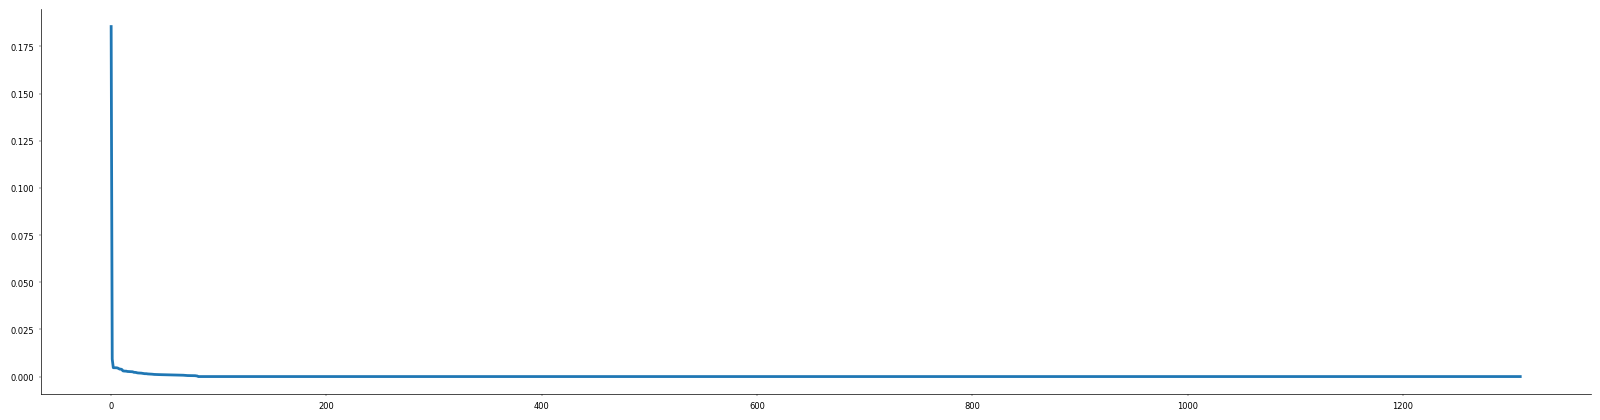

In [105]:
plt.subplots(1, figsize=(20, 5))
plt.plot(np.sort(agreem_mx_m.iloc[0, :])[::-1], linewidth=2)